# SEIR Model 
* Na Jiang (Richard)
* Agent-Based Model for Sythetic population paper use case of disease model

# Modified 4/3:
* Integrated simulated room transmission within the broader SEIR model

## Objective
* Build an ABM to simulate the spread of disease through peoples' social networks

In [5]:
import random
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx
import math
import copy
from numpy.random import default_rng


## 1, Load Data & Networks

In [6]:
#Sample Population
pop = pd.read_csv('Data/U_county_pop.csv').iloc[:,1:]#.set_index('id')
print('Total population in Ulster County', pop.shape)
#Networks
#hhold_networks
hhold_nw = nx.read_adjlist('Data/hhold.csv', delimiter=',')
#daycare
daycare_nw = nx.read_adjlist('Data/daycare_nw.csv', delimiter=',')
#school
school_nw = nx.read_adjlist('Data/school_nw.csv', delimiter=',')
#work
work_nw = nx.read_adjlist('Data/work_nw.csv', delimiter=',')

Total population in Ulster County (153253, 9)


## 2, SEIR Model
* Susceptible: all agent could be susceptible 
* Exposed: the delay of acquisition if infection and infection
* Infectious: confirmed cases
* Recovered: recover from the COVID-19
* Death: Disappear from the world

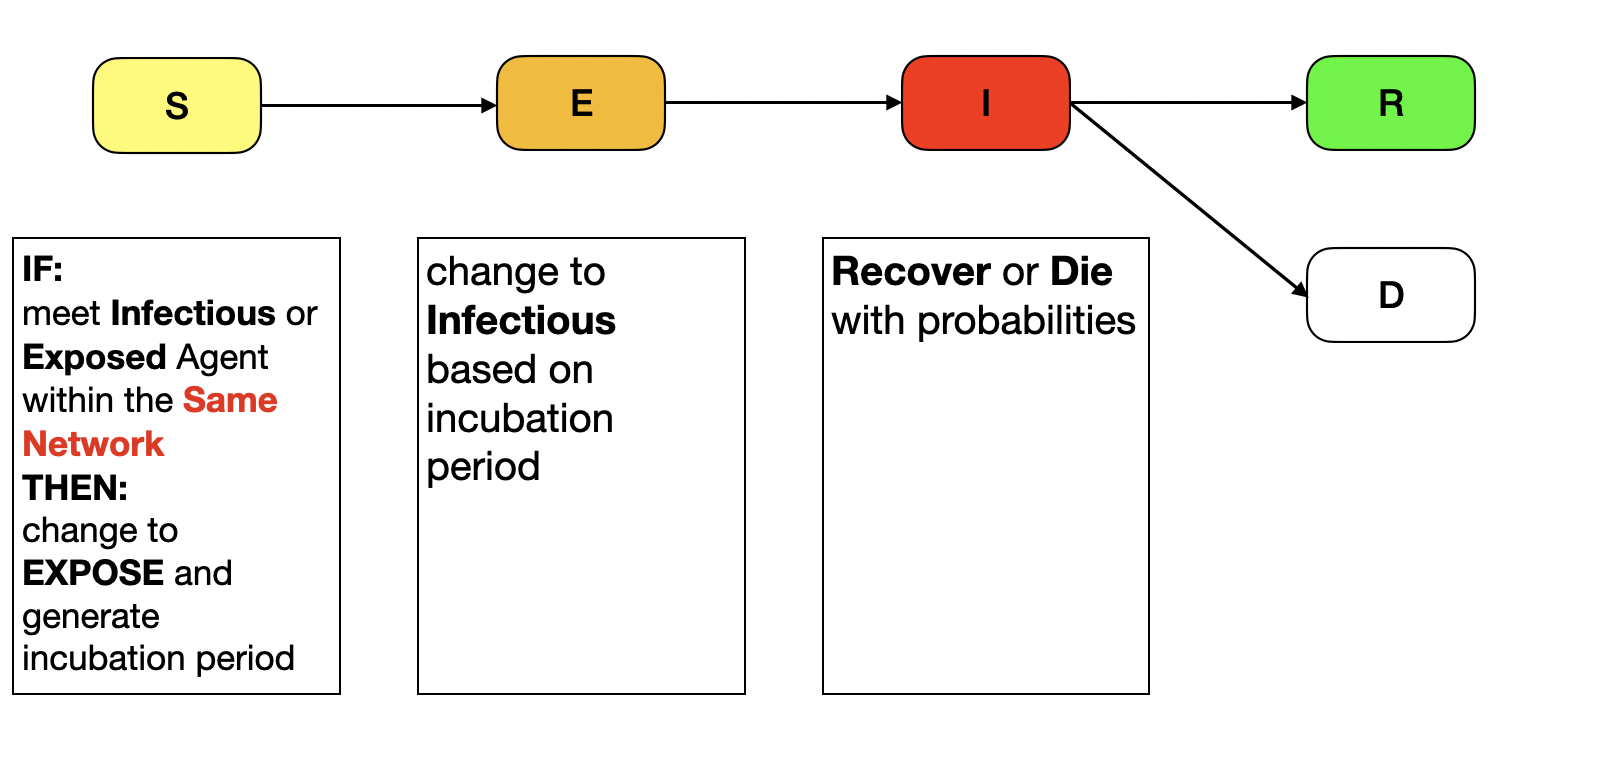

## 3, Agent-Based Model

### 3.1 Set parameter

### 3.2  Agent-Based Model, Simulation

In [7]:
#Random int generator based on normal distribution
def GenBoundedRandomNormal(meanVal, stdDev, lowerBound, upperBound):
    aRand = random.gauss(meanVal,stdDev) # could also use: normalvariate()but gauss () is slightly faster.
    
    while (aRand < lowerBound or aRand > upperBound):
        aRand = random.gauss(meanVal,stdDev)
    return aRand

In [8]:
# Agent class
class Agent(object):
    def __init__(self, World):        
        
        self.id = 0
        self.age = 0
        
        #hhold
        self.hhold_id = []
        self.hhold_size = []
        self.hhold_member = []
        #work
        self.work_id = []
        self.work_size = []
        self.work_member =[]
        
        #S, 0; E, 1; I, 2; R,3; D,4
        self.status = 0
        self.viral_load_idx = 0
        self.viral_load = 0
        #incubation days
        self.incubation = 0
        self.recovery = 0
        #days track
        self.days = 0
        self.location = 0 #if infected in work set 1, if at home set 2
        self.when = 0;

In [9]:
class World(object):
    def __init__(self):
        #Number of Agnets
        self.numberOfAgent = N
        #Generate Agents list
        self.agent = [Agent(self) for i in range(self.numberOfAgent)]
    
    def Init_agents(self, pop, H, W, S, D):#population dataset, hhold network, work network, School network,, dfaycare network
        index_list = []
        id_list = []
        for i in range(self.numberOfAgent):
            index_list.append(i)
            #ID
            self.agent[i].id = str(pop.id[i])
            id_list.append(self.agent[i].id)
            #print(type(self.agent[i].id))
            #age
            self.agent[i].age = int(pop.age[i])
            
            #status
            self.agent[i].status = 0 # set healthy at the initialization
            
            #hhold
            #hhold id
            self.agent[i].hhold_id = pop.hhold[i]
            #hhold size
            self.agent[i].hhold_size = H.degree(self.agent[i].id)
            #hhold member
            self.agent[i].hhold_member = list(H.neighbors(self.agent[i].id))
            
            #work based on age and workplace ID
            self.agent[i].work_id = pop.wp[i]
            
            #Adults
            if self.agent[i].age >= 18:
                #work from home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                else:
                    #work size
                    self.agent[i].work_size = W.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(W.neighbors(self.agent[i].id))
            
            #kids go to daycare
            if self.agent[i].age <= 3:
                #stay at home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                #go to daycare
                else:
                    #daycare nw size
                    self.agent[i].work_size = D.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(D.neighbors(self.agent[i].id))
            
            #kids go to school 
            if (self.agent[i].age < 18) and (self.agent[i].age > 3):
                #daycare nw size
                self.agent[i].work_size = S.degree(self.agent[i].id)
                #work member
                self.agent[i].work_member = list(S.neighbors(self.agent[i].id))  
            
            #incubation day
            self.agent[i].incubation = int(GenBoundedRandomNormal(5, 3, 1, 15)) * 3
            
            self.agent[i].recovery = int(GenBoundedRandomNormal(7, 3, 5, 20)) * 3
            
            #print(i, "Agent ", self.agent[i].id," has", self.agent[i].hhold_size,"family menbers. Current Status", self.agent[i].status, "Incubation:", self.agent[i].incubation, "Days", self.agent[i].days)

        #set a infected agents
        id_dictionary = dict(zip(id_list, index_list))
        #random choose five agents and set them as infected
        for j in range(5):
            x = random.choice(range(N))
            self.agent[x].status = 2   #change status to infected
            self.agent[x].infected = 1 #first day infected
            print("Init_agent->The Infected Nodes is ", x, "status", self.agent[x].status)
        
        return id_dictionary

                  
    def Spread_and_Infect_Home(self, id_dict, DAY):

        ###
        #Use pandas to get agents as a sublist based on household id
        #Pass each element (list) within this list of lists to the infectRoom function
        ###
        #print('Home Networks Spread')
        for i in range(self.numberOfAgent):            
            #Get infected
            #if reach the incubation days, then get  infected
            if (self.agent[i].status == 1) and (self.agent[i].days == self.agent[i].incubation):
                self.agent[i].status = 2
                self.agent[i].days = 0
                self.agent[i].when = DAY #infected day

             
            #Spread the disease, infected lead agent change status to 1
            #status 1 and 2 spread the disease through the network
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):
                for j in range(self.agent[i].hhold_size): 
                    a_id = self.agent[i].hhold_member[j]
                    a_index = id_dict.get(a_id)
                    #print("id", a_id, "its index is", a_index)
                    
                    if (self.agent[a_index].status != 4): 
                        if ((self.agent[a_index].status == 0) ) and (random.random() < 0.2):
                            self.agent[a_index].status = 1
                            self.agent[a_index].days = 0
                            self.agent[a_index].location = 2 #infected at home
                            #self.agent[a_index].when = DAY #infected day
                            #print("Home: Agent get infected,", self.agent[i].status, "at location,", self.agent[a_index].location, "in Day", self.agent[a_index].when)
    
    
    def Spread_and_Infect_Work(self, id_dict, DAY):

        ###
        #Use pandas to get agents as a sublist based on workplace id
        #Pass each element (list) within this list of lists to the infectRoom function
        ###

        for i in range(self.numberOfAgent):            
            #Get infected
            #if reach the incubation days, then get  infected   
            if (self.agent[i].status == 1) and (self.agent[i].days == self.agent[i].incubation):
                self.agent[i].status = 2
                self.agent[i].days = 0
                self.agent[i].when = DAY #infected day
             
            #Spread the disease, infected lead agent change status to 1
            #status 1 and 2 spread the disease through the network
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):
                for j in range(self.agent[i].work_size): 
                    a_id = self.agent[i].work_member[j]
                    #check if the member is in the sample population
                    if a_id not in id_dict.keys():
                        print('Not')
                    else:
                        #print("in")
                        a_index = id_dict.get(a_id)
                        if (self.agent[a_index].status != 4): #and (self.agent[i].interacted > 0):
                            #if ((self.agent[a_index].status == 0) or (self.agent[a_index].status == 3)) and (random.random() < 0.2):
                            if ((self.agent[a_index].status == 0)) and (random.random() < 0.2):
                                self.agent[a_index].status = 1
                                self.agent[a_index].days = 0
                                self.agent[a_index].location = 1 #infected at work
                                
                                #print("Work: Agent get infected,", self.agent[i].status, "at location,", self.agent[a_index].location, "in Day", self.agent[a_index].when)

    
    def Recover(self):
        for i in range(self.numberOfAgent):
            if (self.agent[i].status == 2) and (self.agent[i].days == self.agent[i].recovery):
                dice = random.random()
                #print(self.agent[i].id, "Recover")
                if dice < 0.1:
                    self.agent[i].status = 4 #die
                else:
                    self.agent[i].status = 3 #revover
    
    def Recover_and_Die(self, H, W, S, D): 
        for i in range(self.numberOfAgent):
            if self.agent[i].status != 4:
                dice = random.random()
                #print(dice)
                #Recover
                if (self.agent[i].status == 2) and (dice > 0.8):
                    #print(self.agent[i].id, "Recover")
                    self.agent[i].status = 3
                    self.agent[i].location = 0
            
                #Die
                if (self.agent[i].status == 2) and (dice < 0.01):
                    #print(self.agent[i].id, "Dies")
                        self.agent[i].status = 4
                        #Adults
                        if self.agent[i].age >= 18:
                            #work from home
                            if self.agent[i].work_id == self.agent[i].hhold_id:
                                H.remove_node(self.agent[i].id)
                            else:
                                W.remove_node(self.agent[i].id)
                
                        #kids go to daycare
                        if self.agent[i].age <= 3:
                            #stay at home kids
                            if self.agent[i].work_id == self.agent[i].hhold_id:
                                H.remove_node(self.agent[i].id)
                            else:
                                D.remove_node(self.agent[i].id)
                
                        #kids go to school 
                        if (self.agent[i].age < 18) and (self.agent[i].age > 3):
                            S.remove_node(self.agent[i].id)
                      
    def Update_SEIR_List(self, DAY):
        S = []
        E = []
        I = []
        R = []
        D = []
        
        T = DAY
        for i in range(self.numberOfAgent):
            #D.append(self.agent[i].days)
            
            if self.agent[i].status == 0:
                S.append(self.agent[i].id)
            
            if self.agent[i].status == 1:
                #Update Days
                self.agent[i].days += 1
                E.append(self.agent[i].id) 
                
            if self.agent[i].status == 2: #Update agent.viral_load based on index into kevi file
                self.agent[i].days += 1
                I.append(self.agent[i].id)
                
            if self.agent[i].status == 3:
                R.append(self.agent[i].id)
            
            if self.agent[i].status == 4:
                D.append(self.agent[i].id)
           
        return T, len(S), len(E), len(I), len(R), len(D)
    
    def Get_Location(self, DAY):
        Home = []
        Work = []
        Daycare = []
        School  = [] 
        T = DAY
        #print(T)
        for i in range(self.numberOfAgent):
            if self.agent[i].status == 2:
                #home
                if (self.agent[i].location == 2) and (self.agent[i].when == DAY):
                    #print("Case 1")
                    Home.append(self.agent[i].id)   
                elif (self.agent[i].location == 1) and (self.agent[i].when == DAY):
                    #print("Case 2")
                    #daycare
                    if self.agent[i].age <= 2:
                        #print("Case 2.1")
                        Daycare.append(self.agent[i].id)
                    #school
                    if (self.agent[i].age <= 17) and (self.agent[i].age >= 3): 
                        #print("Case 2.2")
                        School.append(self.agent[i].id)
                    #work
                    if self.agent[i].age >= 18:
                        #print("Case 2.3")
                        Work.append(self.agent[i].id)                
        
        return T, len(Home), len(Work), len(Daycare), len(School)
        

In [ ]:
#Set global variables for room simulation
def globalVars(model):

    rng = default_rng(190319381062290118519841602886838153481)
    float_epsilon = np.finfo(float).eps
    #Map each person to a viral load profile
    #Do this in external network model

    vloads = {}
    for agent in model.agent: #Randomly assign viral load index to each agent in the model
        idx = random.randint(0,10001)
        agent.vload_idx = idx

    meanach = 2.00
    stdach = 2.45

    lowbreathe = 0.51/3600.0
    highbreathe = 1.24/3600.0
    #  lowbreathe = 1.0e-4
    # highbreathe = 2.0e-4

    # Implicit assumption here is that breathing rate is same for all individuals in room
    br_activity = [0.51/3600.0, 0.57/3600.0, 1.24/3600]

    kevi = np.loadtxt('data/Ke_Infectiousness_10000.csv', delimiter = ',', skiprows = 1) #Viral load data

    ibinmax = 17
    kdecay = 1.0
    maskfac_out = 0.0
    maskfac_in = 0.0

    # RESPIRATOR VOLUME EMISSION RATE

    # Define dry bins from 0.1 to 100 um
    # Integrate from 0.1 micron to 100 microns
    nbins = 30
    nleft = -1
    nright = 2
    dlogd = (nright-nleft)/nbins

    dfull = np.zeros(nbins)

    dedge = np.logspace(nleft, nright, nbins+1)

    for i in range(nbins):
        dfull[i] = np.sqrt(dedge[i+1] * dedge[i])

    # Cappa 2 mode model for breathing - note cn here is particles/s
    # Note that cn here is from Cappa 3/10/2022 4:02 am email
    nmodesb  = 2
    cnb = np.array([1.33/(1.33+0.88), 0.88/(1.33+0.88)])
    cmdb = np.array([0.45, 0.87])
    gsdb = np.array([1.58,1.47])

    # Cappa 3 mode model for talking - note cn here is particles/s
    # Note that cn here is from Cappa 2/27/2022 2:52 pm email
    nmodest  = 3
    cnt = np.array([4.3/(4.3+0.1+0.011), 0.1/(4.3+0.1+0.011), 0.011/(4.3+0.1+0.011)])
    cmdt = np.array([0.45, 3.3, 10.5])
    gsdt = np.array([1.96,1.6, 1.6])

    # Set max diameter to 25 um dry ie 100 um wet
    # ibinmax = 24
    # Set max diameter to 5 um dry ie 20 um wet
    ibinmax = 17
    d = dfull[0:ibinmax]
    nemb = np.zeros((ibinmax,nmodesb))
    vemb = np.zeros((ibinmax,nmodesb))
    nemt = np.zeros((ibinmax,nmodest))
    vemt = np.zeros((ibinmax,nmodest))

    # Calculate number (1/s) and volume (um3/s) in each size bin for breathing for 1 p/s
    for im in range(nmodesb):
        for i in range(ibinmax):
            nemb[i,im] = dlogd * np.log(10.0) * cnb[im]/(np.sqrt(2.0*np.pi)*np.log(gsdb[im])) * np.exp(-((np.log(d[i]) - np.log(cmdb[im]))**2)/(2.0*(np.log(gsdb[im]))**2))
            vemb[i,im] = nemb[i,im] * (np.pi * (d[i])**3)/6.0

    # Calculate number (1/s) and volume (um3/s) in each size bin for talking for 1 p/s
    for im in range(nmodest):
        for i in range(ibinmax):
            nemt[i,im] = dlogd * np.log(10.0) * cnt[im]/(np.sqrt(2.0*np.pi)*np.log(gsdt[im])) * np.exp(-((np.log(d[i]) - np.log(cmdt[im]))**2)/(2.0*(np.log(gsdt[im]))**2))
            vemt[i,im] = nemt[i,im] * (np.pi * (d[i])**3)/6.0

    # Total wet volume emission rate for each bin for breathing for p/s = 1.0 in mL/s
    # Scale by 64 for dry to wet volume
    # Multiply by 1e-12 to convert um3/s to mL/s
    vembreathe = 64.0 * 1.0e-12 * np.sum(vemb,axis=1)

    # Total wet volume emission rate for for each bin talking for p/s = 1.0 in mL/s
    # Scale by 64 for dry to wet volume
    # Multiply by 1e-12 to convert um3/s to mL/s
    vemtalk = 64.0 * 1.0e-12 * np.sum(vemt,axis=1)



In [ ]:
def room_pinf(ibinmax,kdecay,lowbreathe,maskfac_out,maskfac_in,
              roomvolx,achx,tendx,talkfractionx,vdotbreathex,
              vemtalk,vembreathe,kdep,fdep,
              nindex_room,nemmx_talk,nemmx_breathe,vinfx):

    # THIS ROUTINE CALCULATE THE PROBABILITY OF INFECTION IN A ROOM ASSUMING WELL-MIXED CONDITIONS AND FAR FIELD TRANSMISSION ONLY

    # NOTE
    # ibinmax,kdecay,lowbreathe,maskfac_out,maskfac_in are scalars that do not change from room to room
    # roomvolx,achx,tendx,talkfractionx,vdotbreathex are scalars that change from room to room 
    # vemtalk,vembreathe,kdep,fdep have dimension ibinmax and do no change from room to room
    # nemmx_talk,nemmx_breathe,vinfx have dimension nindex_room and change from room to room

    rnaconc = np.zeros((ibinmax,nindex_room))
    #nindex_room is the number of index cases in the room
    #can fill this value at room assignment
    id50 = 1.0
    dose = 0.0

    for ibin in range(ibinmax):
        # Aerosol volume emission rate in each bin (mL/s)
        # nemmx_talk and nemmx_breathe are for lowbreathe  - scale by actual breathing
        vaerosol = talkfractionx * (nemmx_talk * vdotbreathex/lowbreathe) * vemtalk[ibin] + (1.0 - talkfractionx) * (nemmx_breathe * vdotbreathex/lowbreathe) * vembreathe[ibin] 
        #talk fraction comes from uniform -> can be assigned ahead of time
        #
        # Loss coefficient (1/s)
        kloss = (kdecay + kdep[ibin] + achx)/3600.0 

        # CONCENTRATION IN WELL-MIXED CASE
        rnaconc[ibin,:] = ((1.0 - maskfac_out)*vinfx[:]*vaerosol)/(kloss*roomvolx) * (1.0 - (1 - np.exp(-kloss * tendx))/(kloss * tendx))

    # CALCULATE TOTAL RNA CONCENTRATION IN EACH BIN FROM ALL INDEX CASES IN ROOM
    totrnaconc = np.sum(rnaconc, axis=1)

    # CALCULATE DOSE FOR WELL MIXED CASE)
    for ibin in range(ibinmax):
        # DOSE FOR SUSCEPTIBLE IN WELL-MIXED CASE
        dose = dose + (1-maskfac_in)*fdep[ibin]*totrnaconc[ibin] * vdotbreathex * tendx

    # INFECTION PROBABILITY FOR SUSCEPTIBLE IN WELL MIXED CASE
    pinfx = 1.0 - np.exp(-dose/id50)

    return pinfx

In [ ]:
#Some variables listed undefined, but set as global vars
from scipy.stats import truncnorm

def infectRoom(room, model):
    indexcases = [agent for agent in room where agent.status == 2]
    nindex_room =  len(indexcases) #Room should be a list of agent objects
    areapp = random.uniform(1,10)
    roomarea = (1 + (len(room)-nindex_room))*areapp
    roomheight = 3.0
    roomvol = roomheight*roomarea
    mu_ach = np.log(meanach*meanach/np.sqrt(meanach*meanach + stdach*stdach))
    sigma_ach = np.sqrt(np.log(1.0 + stdach*stdach/(meanach*meanach)))
    ach = rng.lognormal(mu_ach,sigma_ach)

    mu_tend = np.log(1.0)
    sigma_tend=0.5
    lntend_min = np.log(0.1)
    lntend_max = np.log(3.0+float_epsilon)
    aclip = (lntend_min - mu_tend)/sigma_tend
    bclip = (lntend_max - mu_tend)/sigma_tend

    lntend_clip = truncnorm.rvs(aclip, bclip, loc=mu_tend, scale=sigma_tend,random_state=rng)
    tend = 3600.0*np.exp(lntend_clip)

    talkfraction = rng.uniform(low=0.05,high=0.25+float_epsilon)

    activityindex = rng.choice(3)
    vdotbreathe=br_activity[activityindex]


    mean = 3.4*13
    std = 2.7*13
    mu = np.log(mean*mean/np.sqrt(mean*mean + std*std))
    sigma = np.sqrt(np.log(1.0 + std*std/(mean*mean)))
    lmax = np.log(20.0*13)
    bclip = (lmax - mu)/sigma
    lclip = truncnorm.rvs(-np.inf, bclip, loc=mu, scale=sigma, size= model.numberOfAgent,random_state = rng)
    nemm_talk = np.exp(lclip)
    nemm_talk_room = [nemm_talk[i] for i in room if room[i].status == 2]

    mub = np.log(8) - 0.48*np.log(10)
    sigmab = 0.85*np.log(10)/(np.sqrt(2))
    nemm_breathe = rng.lognormal(mub, sigmab, size= model.numberOfAgent)
    nemm_breathe_room = [nemm_breathe[i] for i in room if room[i].status == 2]

    vinf = []
    for person in room:
        if person.status == 2:
            load = kevi[person.days][person.viral_load_idx]
            vinf.append(load)

    pinf = room_pinf(ibinmax,kdecay,lowbreathe,maskfac_out,maskfac_in, #global vars
            roomvol,ach,tend,talkfraction,vdotbreathe, #global vars
            vemtalk,vembreathe,kdep,fdep, #**THESE ARE NOT DEFINED YET**
            nindex_room,nemm_talk,nemm_breathe,vinf) 
    
    return pinf
                


## 4 Simulation Results and Analysis

### 4.1 Simulation Class

In [10]:
class Sim(object):
    def __init__(self):
        self.World = World()
        self.df = pd.DataFrame([])
       
    def Run(self, H, W, S, D, DAYS):
        steps = DAYS * 3
        print("Simulation steps:", steps)
        
        id_d = self.World.Init_agents(pop, H, W, S, D) 
        #print(type(id_d))
        #print(id_d)
        
        Results = []
        Location = []

        day = 0
        for i in range(0,steps):
            if i % 3 == 0:
                #SEIR
                t, x1, x2, x3, x4, x5 = self.World.Update_SEIR_List(day)
                Results.append([t, x1, x2, x3, x4, x5])
                
                #Location
                time, h, w, d, s = self.World.Get_Location(day)
                Location.append([time, h, w, d, s])
                
                if day % 10 == 0:
                    print("Current Day: ", day)
                day = day + 1

            if (i % 3 == 0):
                #print("Day:", day,"Moring")
                self.World.Spread_and_Infect_Home(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])
    
            if i % 3 == 1:
                #print("Day:", day,"Daytime")
                self.World.Spread_and_Infect_Work(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])
        
            if i % 3 == 2:
                #print("Day:", day,"Evening")
                self.World.Spread_and_Infect_Home(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])            
     
        #SEIR
        df1 =  pd.DataFrame(Results, columns=['Day','S', 'E', 'I', 'R', 'D']) 
        #Location
        df2 = pd.DataFrame(Location, columns=['Day','Home', 'Work', 'Daycare', 'School'])
        return df1, df2

## 4.2 Set Model Parametters 

In [11]:
# Number of agents
N = len(pop)
print("Population size", N)
#Number of Days
DAYS = 60
print("Simulation of ", DAYS, "days")

Population size 153253
Simulation of  60 days


## 4.3 Simulation Experiemnt

In [12]:
if __name__ == '__main__':
    aSim = Sim()
    print ("simulation starts...")
    #Network
    H = deepcopy(hhold_nw)
    W = deepcopy(work_nw)
    S = deepcopy(school_nw)
    D = deepcopy(daycare_nw)
    SEIR, Loc = aSim.Run(H, W, S, D, DAYS)
    print("Done~")

simulation starts...
Simulation steps: 180
Init_agent->The Infected Nodes is  191 status 2
Init_agent->The Infected Nodes is  48891 status 2
Init_agent->The Infected Nodes is  124447 status 2
Init_agent->The Infected Nodes is  27703 status 2
Init_agent->The Infected Nodes is  34483 status 2
Current Day:  0
Current Day:  10
Current Day:  20
Current Day:  30
Current Day:  40
Current Day:  50
Done~


## 4.4 Visualization of Simulation Results
### 4.4.1 SEIR Plot

In [13]:
def plot_SEIR(df):
    print(df.head())    
    plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    plt.plot(df.index, df.S, marker='o', markerfacecolor='gray', markersize=2, color='skyblue', linewidth=2)
    plt.plot(df.index, df.E, marker='o', markerfacecolor='gray', markersize=2, color='yellow', linewidth=2)
    plt.plot(df.index, df.I, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, df.R, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    plt.plot(df.index, df.D, marker='o', markerfacecolor='gray', markersize=2, color='black', linewidth=2)    
    plt.legend(('Susceptible', 'Exposed', 'Infectious','Recovered', 'Dead'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper right', ncol = 5)  
    plt.gcf().autofmt_xdate() #italics of x label   
    plt.savefig('SEIR_WL.png')

   Day       S    E  I  R  D
0    0  153248    0  5  0  0
1    1  153224   24  5  0  0
2    2  153167   81  5  0  0
3    3  152963  285  5  0  0
4    4  152388  860  5  0  0


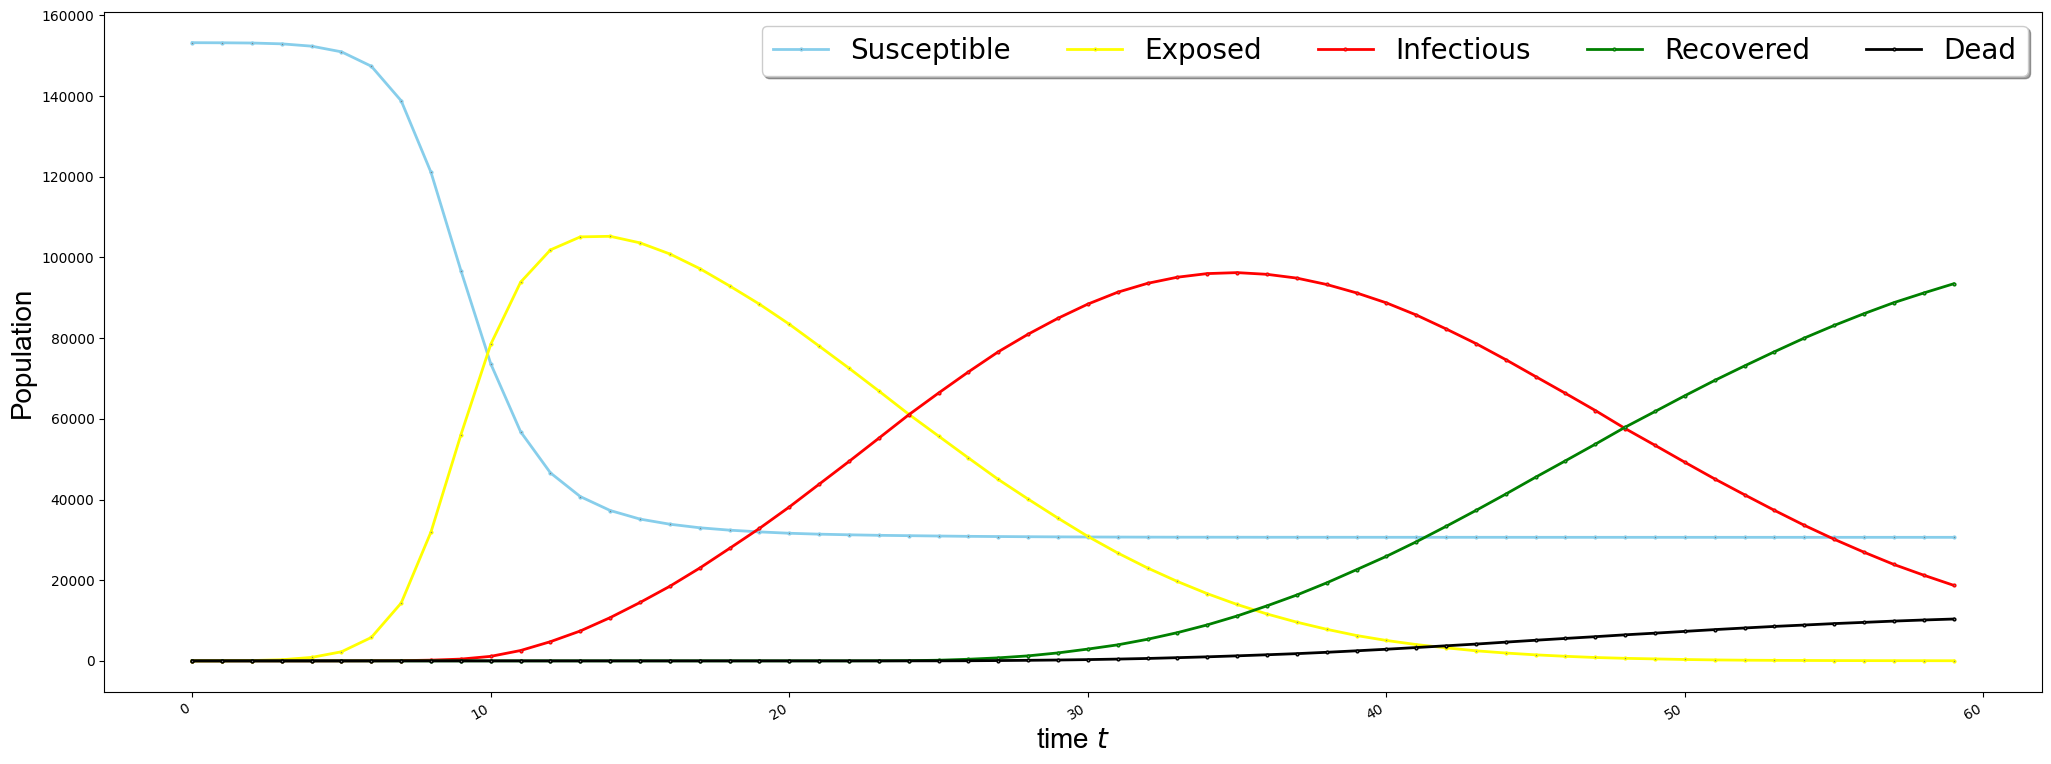

In [14]:
plot_SEIR(SEIR)

### 4.4.2 Infected Loactions

In [15]:
def plot_Loc(df):    
    plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    #extract data
    temp1 = list(df.Home)
    temp2 = list(df.Work)
    temp3 = list(df.Daycare)
    temp4 = list(df.School)
    #New list to plot
    home = []
    work = []
    daycare = []
    school  = []
    
    for i in range(len(temp1)):
        if i == 0:
            home.append(temp1[i])
            work.append(temp2[i])
            daycare.append(temp3[i])
            school.append(temp4[i])
        if i != 0:
            h = home[i - 1] + temp1[i]
            w = work[i - 1] + temp2[i]
            d = daycare[i - 1] + temp3[i]
            s = school[i - 1] + temp4[i]
        
            home.append(h)
            work.append(w)
            daycare.append(d)
            school.append(s)
    plt.plot(df.index, home, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    plt.plot(df.index, work, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, daycare, marker='o', markerfacecolor='gray', markersize=2, color='orange', linewidth=2)
    plt.plot(df.index, school, marker='o', markerfacecolor='gray', markersize=2, color='blue', linewidth=2)      
    plt.legend(('Home', 'Work', 'Daycare','School'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper left', ncol = 4)    
    plt.gcf().autofmt_xdate() #italics of x label 
    plt.savefig('Home_Work_Infected_wL.png')

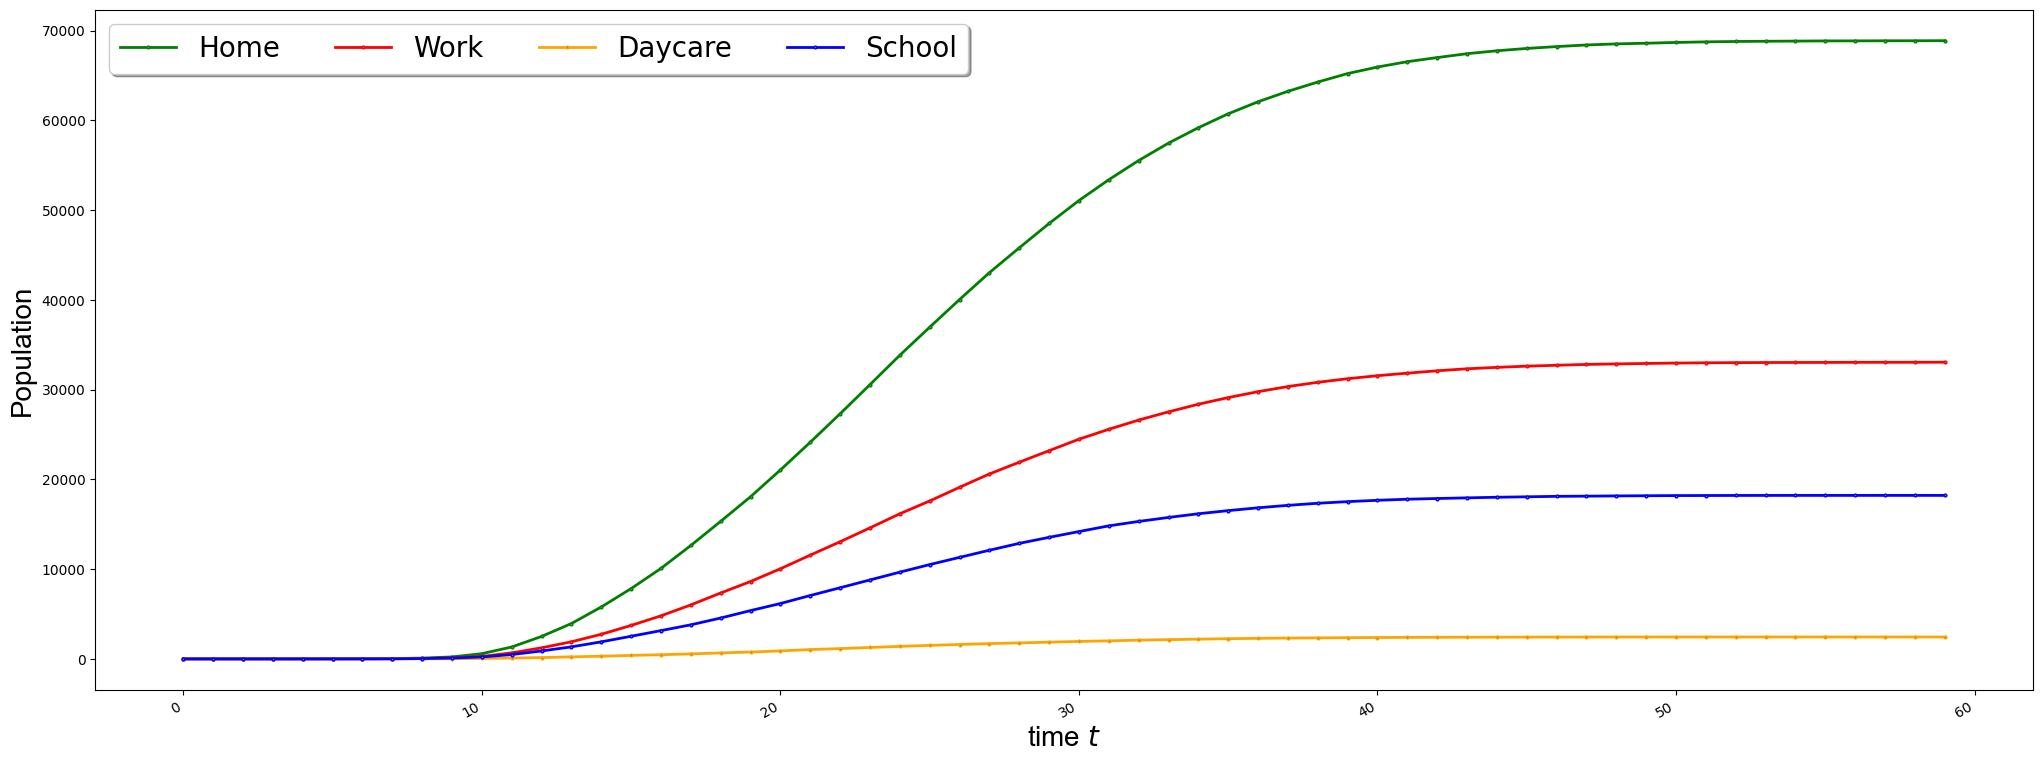

In [16]:
plot_Loc(Loc)